In [1]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import colormath

In [2]:
model_name = 'SNCWGAN/'
root = '/work3/s212645/Spectral_Reconstruction/checkpoint/'
metrics = 'metrics.pth'
path = root + model_name + metrics
result = torch.load(path, map_location=torch.device('cpu'))

In [3]:
MRAE = result['MRAE']
RMSE = result['RMSE']
PSNR = result['PSNR']
SAM = result['SAM']
length = len(MRAE)
for i in range(length):
    MRAE[i] = MRAE[i].item()
for i in range(length):
    RMSE[i] = RMSE[i].item()
for i in range(length):
    PSNR[i] = PSNR[i].item()
for i in range(length):
    SAM[i] = SAM[i].item()


Text(0.5, 1.0, 'SAM')

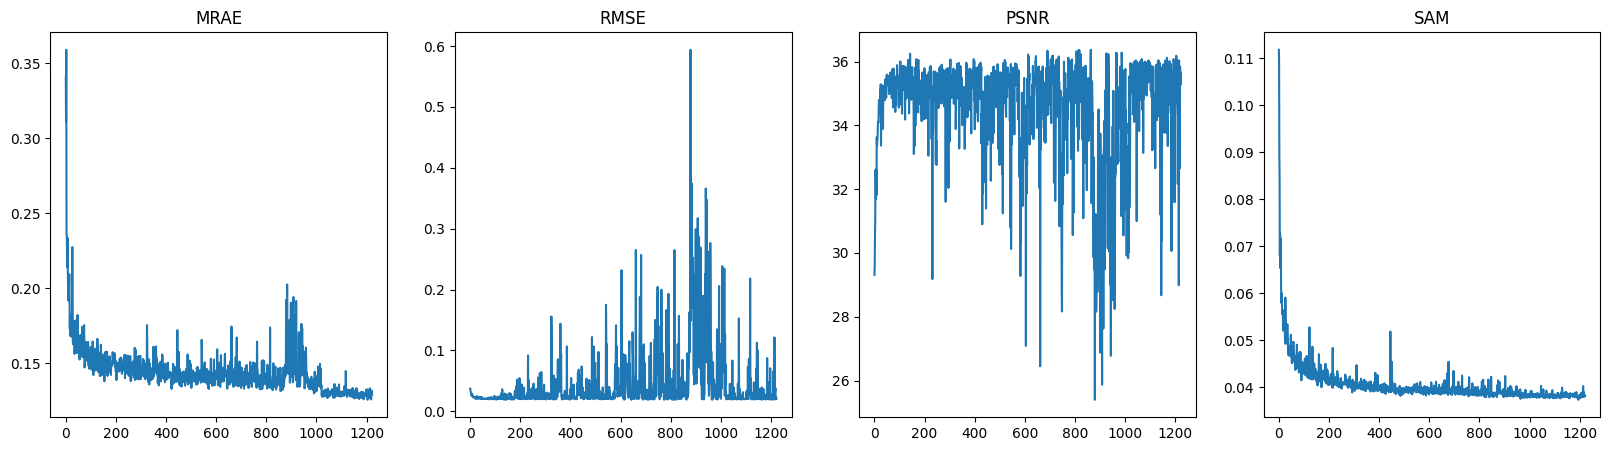

In [4]:
plt.figure(figsize=[20,5])
plt.subplot(1, 4, 1)
plt.plot(range(length), MRAE)
plt.title("MRAE")

plt.subplot(1, 4, 2)
plt.plot(range(length), RMSE)
plt.title("RMSE")

plt.subplot(1, 4, 3)
plt.plot(range(length), PSNR)
plt.title("PSNR")

plt.subplot(1, 4, 4)
plt.plot(range(length), SAM)
plt.title("SAM")


In [5]:
import scipy.io
import numpy as np
import cv2

Text(0.5, 1.0, 'Fake Generation')

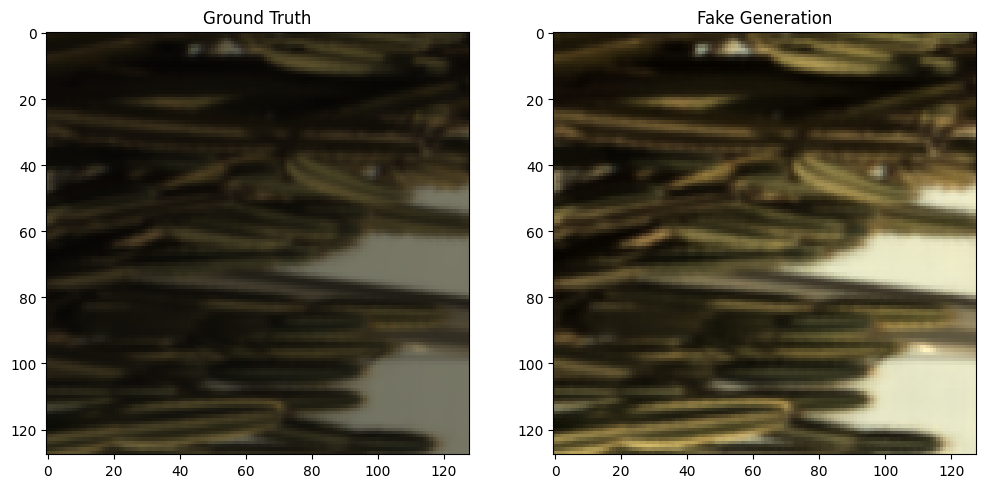

In [13]:
realroot = '/work3/s212645/Spectral_Reconstruction/RealHyperSpectrum_D2GAN/'
fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum_D2GAN/'

name = '008.mat'

fake = scipy.io.loadmat(fakeroot + name)['rgb']
fake = (fake - fake.min()) / (fake.max()-fake.min())

real = scipy.io.loadmat(realroot + name)['rgb']
real = (real - real.min()) / (real.max()-real.min())

plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.imshow(real)
plt.title('Ground Truth')
plt.subplot(1, 2, 2)
plt.imshow(fake)
plt.title('Fake Generation')

In [14]:
import colour
image1_lab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(real))
image2_lab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(fake))
colour.delta_E(image1_lab, image2_lab).mean()

12.220778605384581